In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from typing import Tuple, Iterable
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tempfile import TemporaryDirectory
import os

In [2]:
BATCH_SIZE=64

In [3]:
# Let's define the class object of multilayer perceptrons
class DNN(torch.nn.Module):
    def __init__(self, width_vec: list = None):
        super(DNN, self).__init__()
        self.width_vec= width_vec

        modules = []
        if width_vec is None:
            width_vec = [1,256,256,256,1]

        # Network
        for i in range(len(width_vec) - 2):
            modules.append(nn.Linear(width_vec[i],width_vec[i+1]));
            modules.append(nn.ReLU())

        self.net = nn.Sequential(*modules,
                                 nn.Linear(width_vec[-2],width_vec[-1])
                                 )

    def forward(self,x):
        output = self.net(x)
        return  output

In [4]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, attributes, target):
        self.attributes = attributes
        self.target = target

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.attributes)

    def __getitem__(self, index):
        X = torch.tensor(self.attributes[index], dtype=torch.float)
        y = torch.tensor(self.target[index], dtype=torch.float)

        return X, y


In [5]:
df = pd.read_csv('data/Train_Data_Converted&Dropped.csv')
df.head()

,number of rooms,security level of the community,residence space,building space,noise level,waterfront,view,air quality level,aboveground space,basement space,building year,exchange rate,LAT,LNG,timestamp,transaction year,transaction month,transaction day,filled decoration year,total
0,5,2.50,2820,67518,2.0,0,0,3,2820,0,1979,6.784830,47.557085,-122.007748,1398988800,2014,5,2,2014,675000.000105
1,2,1.00,1210,9400,1.0,0,0,2,1210,0,1949,6.243129,47.544034,-122.349874,1398988800,2014,5,2,1949,234999.999988
2,4,2.50,2200,9397,2.0,0,0,3,2200,0,1987,6.010127,47.310617,-122.263291,1398988800,2014,5,2,2000,237227.857125
3,3,1.50,1200,9720,1.0,0,0,4,1200,0,1965,7.560375,47.367737,-122.117029,1398988800,2014,5,2,1965,242499.999935
4,3,1.75,1370,5858,1.0,0,0,3,1370,0,1987,6.543941,47.391319,-122.314971,1398988800,2014,5,2,2000,257949.999962


In [6]:
attributes_scaler = MinMaxScaler()
attributes_data = attributes_scaler.fit_transform(df.drop(['total'], axis=1))
target_scaler = MinMaxScaler()
target_data = target_scaler.fit_transform(df['total'].to_numpy().reshape(-1, 1))
df = pd.concat([
     pd.DataFrame(attributes_data, columns=df.columns[:-1]),
     pd.DataFrame(target_data.squeeze(), columns=['total'])
 ], axis=1)
df.head()

,number of rooms,security level of the community,residence space,building space,noise level,waterfront,view,air quality level,aboveground space,basement space,building year,exchange rate,LAT,LNG,timestamp,transaction year,transaction month,transaction day,filled decoration year,total
0,0.555556,0.31250,0.182304,0.217492,0.4,0.0,0.0,0.50,0.266147,0.0,0.692982,0.392235,0.625836,0.389753,0.0,0.0,0.0,0.033333,1.000000,0.211895
1,0.222222,0.12500,0.059497,0.028185,0.0,0.0,0.0,0.25,0.086860,0.0,0.429825,0.121247,0.601863,0.103344,0.0,0.0,0.0,0.033333,0.424779,0.055199
2,0.444444,0.31250,0.135011,0.028175,0.4,0.0,0.0,0.50,0.197105,0.0,0.763158,0.004686,0.173113,0.175826,0.0,0.0,0.0,0.033333,0.876106,0.055993
3,0.333333,0.18750,0.058734,0.029228,0.0,0.0,0.0,0.75,0.085746,0.0,0.570175,0.780206,0.278033,0.298269,0.0,0.0,0.0,0.033333,0.566372,0.057870
4,0.333333,0.21875,0.071701,0.016648,0.0,0.0,0.0,0.50,0.104677,0.0,0.763158,0.271729,0.321350,0.132563,0.0,0.0,0.0,0.033333,0.876106,0.063373


In [7]:
# generator = torch.random.manual_seed(42)
# train, valid = random_split(df.values, [0.9, 0.1], generator)

In [8]:
# train = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=2)
# valid = DataLoader(valid, BATCH_SIZE, shuffle=True, num_workers=1)

In [9]:
dataset = Dataset(df.drop(['total', 'transaction year', 'transaction month', 'transaction day', 'timestamp'], axis=1).values, df['total'].values)

In [10]:
dataset[0]

(tensor([0.5556, 0.3125, 0.1823, 0.2175, 0.4000, 0.0000, 0.0000, 0.5000, 0.2661,
         0.0000, 0.6930, 0.3922, 0.6258, 0.3898, 1.0000]),
 tensor(0.2119))

In [11]:
generator = torch.random.manual_seed(42)
train, valid = random_split(dataset, [0.9, 0.1], generator)

In [12]:
train_set = DataLoader(train, BATCH_SIZE, shuffle=True, )
valid_set = DataLoader(valid, BATCH_SIZE, shuffle=True)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
i, (X, y) = next(enumerate(train_set))

In [15]:
X.shape

torch.Size([64, 15])

In [16]:
len(train_set)

54

In [17]:
def to_level(l: Iterable):
    def tier(cost: float):
        if 0 <= cost < 300000: return 1
        elif 300000 <= cost < 500000: return 2
        elif 500000 <= cost < 700000: return 3
        elif 700000 <= cost: return 4
    return np.array([tier(c) for c in l])



In [18]:
def evaluator(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    acc = list()
    with torch.no_grad():
        for X, y in dataloader:
            shape_X = X.shape
            X, y = X.reshape(shape_X[0], 1, shape_X[1]).to(device), y.to(device)
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()
            acc.append((to_level(target_scaler.inverse_transform(pred.detach().numpy().reshape(-1, 1))) == to_level(target_scaler.inverse_transform(y.reshape(-1, 1)).squeeze())).sum()/len(y))
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    avg_acc = np.mean(acc)
    print('Avg loss: {:8f}, Avg evaluation accuracy: {:.8f}'.format(test_loss, avg_acc))
    return test_loss, avg_acc

In [19]:
# model = DNN([15, 256, 256, 256, 1]).to(device)

In [20]:
DROP_RATE = 0.
model = torch.nn.Sequential(
    nn.Conv1d(1, 8, 1),
    nn.Conv1d(8, 32, 3),
    nn.AvgPool1d(3),
    nn.Flatten(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Dropout1d(DROP_RATE),
    nn.Linear(16, 1)
).to(device)
print(model)

Sequential(
  (0): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
  (1): Conv1d(8, 32, kernel_size=(3,), stride=(1,))
  (2): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout1d(p=0.0, inplace=False)
  (9): Linear(in_features=16, out_features=1, bias=True)
)


In [21]:
model(torch.randn((32, 1, 15))).shape

torch.Size([32, 1])

In [22]:
loss_fn = torch.nn.MSELoss(reduction='sum')
lr = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5, verbose=True)
EPOCH = 200


Adjusting learning rate of group 0 to 5.0000e-03.


In [23]:
def trainer(dataloader: torch.utils.data.DataLoader,
            model: torch.nn.Module,
            optimizer,
            loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    acc = list()
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        shape_X = X.shape
        X, y = X.reshape(shape_X[0], 1, shape_X[1]).to(device), y.to(device)
        tiers = to_level(y)

        # Compute prediction error
        pred = model(X).squeeze()
        # tiers_pred = to_level(pred)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        acc.append((to_level(target_scaler.inverse_transform(pred.detach().numpy().reshape(-1, 1))) == to_level(target_scaler.inverse_transform(y.reshape(-1, 1)).squeeze())).sum()/len(y))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= num_batches
    avg_acc = np.mean(acc)
    print(f"Avg Train loss: {loss:>8f}, Avg accuracy: {avg_acc:8f}")
    return train_loss, avg_acc

In [24]:
def evaluator(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    acc = list()
    with torch.no_grad():
        for X, y in dataloader:
            shape_X = X.shape
            X, y = X.reshape(shape_X[0], 1, shape_X[1]).to(device), y.to(device)
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()
            acc.append((to_level(target_scaler.inverse_transform(pred.detach().numpy().reshape(-1, 1))) == to_level(target_scaler.inverse_transform(y.reshape(-1, 1)).squeeze())).sum()/len(y))
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    avg_acc = np.mean(acc)
    print('Avg loss: {:8f}, Avg evaluation accuracy: {:.8f}'.format(test_loss, avg_acc))
    return test_loss, avg_acc

In [25]:
train_loss = list()
train_acc = list()
valid_loss = list()
valid_acc = list()

best_val_loss = float('inf')
with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
    for e in range(EPOCH):
        c_train_loss, c_train_acc = trainer(train_set, model, optimizer, loss_fn)
        train_loss.append(c_train_loss)
        train_acc.append(c_train_acc)
        c_valid_loss, c_valid_acc = evaluator(valid_set, model, loss_fn)
        valid_loss.append(c_valid_loss)
        valid_acc.append(c_valid_acc)
        scheduler.step()
        if c_valid_loss < best_val_loss:
            best_val_loss = c_valid_loss
            torch.save(model.state_dict(), best_model_params_path)
    model.load_state_dict(torch.load(best_model_params_path))
output_df = pd.DataFrame({'train loss': train_loss,
                          'valid loss': valid_loss,
                          'train avg accuracy': train_acc,
                          'valid avg accuracy': valid_acc})

Avg Train loss: 0.311357, Avg accuracy: 0.289641
Avg loss: 0.483184, Avg evaluation accuracy: 0.33232527
Adjusting learning rate of group 0 to 5.0000e-03.
Avg Train loss: 0.102452, Avg accuracy: 0.467496
Avg loss: 0.289110, Avg evaluation accuracy: 0.53141801
Adjusting learning rate of group 0 to 5.0000e-03.
Avg Train loss: 0.207275, Avg accuracy: 0.514082
Avg loss: 0.258056, Avg evaluation accuracy: 0.56779234
Adjusting learning rate of group 0 to 5.0000e-03.
Avg Train loss: 0.227610, Avg accuracy: 0.544753
Avg loss: 0.268956, Avg evaluation accuracy: 0.56535618
Adjusting learning rate of group 0 to 5.0000e-03.
Avg Train loss: 0.144709, Avg accuracy: 0.545910
Avg loss: 0.332868, Avg evaluation accuracy: 0.54208669
Adjusting learning rate of group 0 to 5.0000e-03.
Avg Train loss: 0.076225, Avg accuracy: 0.554109
Avg loss: 0.314804, Avg evaluation accuracy: 0.44254032
Adjusting learning rate of group 0 to 5.0000e-03.
Avg Train loss: 0.125910, Avg accuracy: 0.563754
Avg loss: 0.255892, A

<AxesSubplot: title={'center': 'accuracy'}>

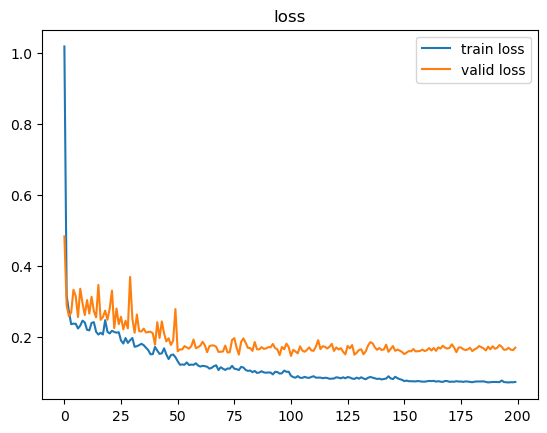

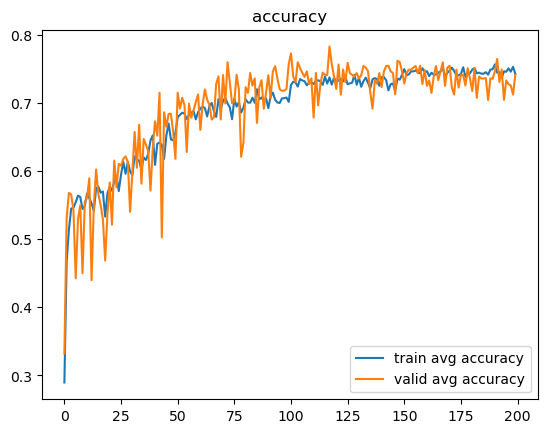

In [26]:
output_df[['train loss', 'valid loss']].plot(legend=True, title='loss')
output_df[['train avg accuracy', 'valid avg accuracy']].plot( legend=True, title='accuracy')


In [27]:
output_df[['train loss', 'valid loss']].min(axis=0)

train loss    0.071717
valid loss    0.146617
dtype: float64

In [28]:
output_df[['train avg accuracy', 'valid avg accuracy']].max(axis=0)

train avg accuracy    0.756269
valid avg accuracy    0.782510
dtype: float64

predict

In [206]:
df_test = pd.read_csv('data/Test_Data_Converted&Dropped.csv')
df_test.columns

Index(['number of rooms', 'security level of the community', 'residence space',
       'building space', 'noise level', 'waterfront', 'view',
       'air quality level', 'aboveground space ', 'basement space',
       'building year', 'exchange rate', 'LAT', 'LNG', 'timestamp',
       'transaction year', 'transaction month', 'transaction day',
       'filled decoration year', 'total cost'],
      dtype='object')

In [207]:
df_test.head()

,number of rooms,security level of the community,residence space,building space,noise level,waterfront,view,air quality level,aboveground space,basement space,building year,exchange rate,LAT,LNG,timestamp,transaction year,transaction month,transaction day,filled decoration year,total cost
0,4,2.5,2920,4000,1.5,0,0,5,1910,1010,1909,6.711048,47.659861,-122.284977,1398988800,2014,5,2,1988,NaN
1,2,1.0,800,4850,1.0,0,0,4,800,0,1944,6.645782,47.667527,-122.377551,1398988800,2014,5,2,1944,NaN
2,2,1.0,880,6380,1.0,0,0,3,880,0,1938,6.224348,47.685746,-122.281589,1398988800,2014,5,2,1994,NaN
3,5,2.5,3650,9050,2.0,0,4,5,3370,280,1921,6.668946,47.638679,-122.370946,1398988800,2014,5,2,1921,NaN
4,2,1.0,900,5000,1.0,0,0,3,900,0,1944,7.244343,47.687761,-122.384870,1399075200,2014,5,3,1944,NaN


In [208]:
df_test_rescaled = pd.concat([
    pd.DataFrame(attributes_scaler.transform(df_test.drop(['total cost'], axis=1))),
    df_test['total cost']]
,axis=1)
df_test_rescaled.columns = df_test.columns
df_test_rescaled.head()

,number of rooms,security level of the community,residence space,building space,noise level,waterfront,view,air quality level,aboveground space,basement space,building year,exchange rate,LAT,LNG,timestamp,transaction year,transaction month,transaction day,filled decoration year,total cost
0,0.444444,0.3125,0.189931,0.010596,0.2,0.0,0.0,1.00,0.164811,0.244552,0.078947,0.355326,0.814619,0.157672,0.000000,0.0,0.0,0.033333,0.769912,NaN
1,0.222222,0.1250,0.028223,0.013365,0.0,0.0,0.0,0.75,0.041203,0.000000,0.385965,0.322676,0.828700,0.080174,0.000000,0.0,0.0,0.033333,0.380531,NaN
2,0.222222,0.1250,0.034325,0.018348,0.0,0.0,0.0,0.50,0.050111,0.000000,0.333333,0.111851,0.862165,0.160508,0.000000,0.0,0.0,0.033333,0.823009,NaN
3,0.555556,0.3125,0.245614,0.027045,0.4,0.0,1.0,1.00,0.327394,0.067797,0.184211,0.334264,0.775711,0.085704,0.000000,0.0,0.0,0.033333,0.176991,NaN
4,0.222222,0.1250,0.035850,0.013853,0.0,0.0,0.0,0.50,0.052339,0.000000,0.385965,0.622109,0.865867,0.074047,0.014493,0.0,0.0,0.066667,0.380531,NaN


In [209]:
test = Dataset(df_test_rescaled.drop(['total cost', 'transaction year', 'transaction month', 'transaction day', 'timestamp'], axis=1).values, df_test_rescaled['total cost'])
test_set = DataLoader(test, BATCH_SIZE, shuffle=True)

In [210]:
def predictor(dataloader, model):
    model.eval()
    pred_arr = list()
    for X, y in dataloader:
        shape_X = X.shape
        X, y = X.reshape(shape_X[0], 1, shape_X[1]).to(device), y.to(device)
        pred = model(X).squeeze()
        pred_arr.extend(to_level(target_scaler.inverse_transform(pred.detach().numpy().reshape(-1, 1))))
    return pred_arr

In [211]:
pred_ys = predictor(test_set, model)

In [212]:
pred_level = pd.DataFrame({'price range': pred_ys})

prediction distribution

Text(0.5, 1.0, '')

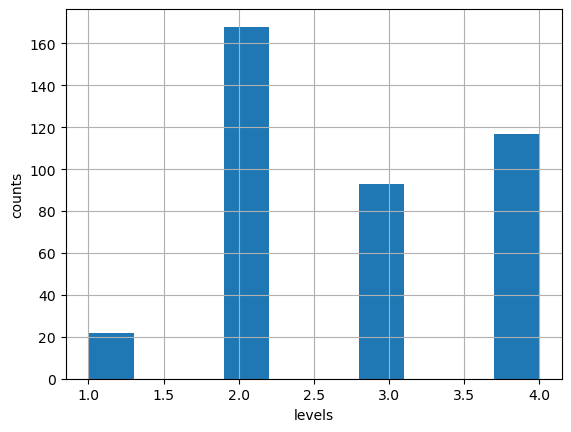

In [213]:
ax = pred_level.hist()
ax[0][0].set_xlabel('levels')
ax[0][0].set_ylabel('counts')
ax[0][0].set_title('')

original distribution

Text(0.5, 1.0, '')

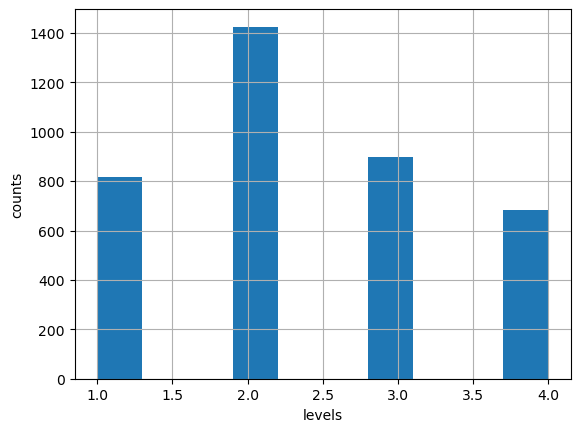

In [214]:

ax = pd.DataFrame(to_level(target_scaler.inverse_transform(df['total'].values.reshape(-1, 1)))).hist()
ax[0][0].set_xlabel('levels')
ax[0][0].set_ylabel('counts')
ax[0][0].set_title('')

In [215]:
df_pred = pd.concat([
    df_test.drop(['total cost'], axis=1),
    pred_level
], axis=1)

In [218]:
df_pred.to_csv('data/Test_Data_Predicted.csv', index=False)